## Observations and Insights 

In [57]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

# Combine the data into a single dataset
df = pd.merge(mouse_metadata_df, study_results_df, how="left", on="Mouse ID")

# Display the data table for preview
df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Check the number of mice.
num_mice = len(df["Mouse ID"].unique())
num_mice

249

In [3]:
# Find any duplicate rows with the same Mouse IDs and Timepoints. 
dup_mice = df[df.duplicated(["Mouse ID", "Timepoint"], keep=False)]

# Check for number of different mice with duplicates
len(dup_mice["Mouse ID"].unique())

1

In [4]:
# Drop any duplicate rows
df = df.drop(df.loc[df["Mouse ID"]==dup_mice.iloc[1,0]].index)

In [5]:
# Recheck the number of mice
num_mice = len(df["Mouse ID"].unique())
num_mice

248

## Summary Statistics

In [6]:
# Generate a summary statistics table of mean, median, variance, 
# standard deviation, and SEM of the tumor volume for each regimen.
drug_gb = df.groupby("Drug Regimen")

summary = pd.DataFrame({
    "Mean": drug_gb["Tumor Volume (mm3)"].mean(),
    "Median": drug_gb["Tumor Volume (mm3)"].median(),
    "Variance": drug_gb["Tumor Volume (mm3)"].var(),
    "Std Dev": drug_gb["Tumor Volume (mm3)"].std(),
    "SEM": drug_gb["Tumor Volume (mm3)"].sem()
})
summary.style.set_caption("Tumor Volume Statistics by Regimen")

,Mean,Median,Variance,Std Dev,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

Text(0, 0.5, 'Number of Data Points')

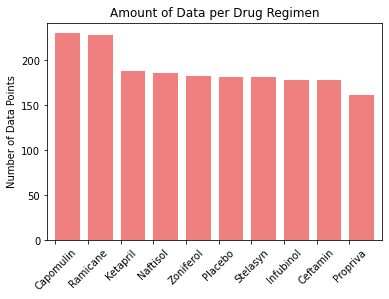

In [60]:
# Generate a bar plot showing the total number of datapoints for each drug regimen using pandas.
# There should be a single bar per regimen
ax = df["Drug Regimen"].value_counts().plot.bar(title="Amount of Data per Drug Regimen", 
                                           color="lightcoral", 
                                           width=0.75, 
                                           align="edge", 
                                           rot=45)
ax.set_ylabel("Number of Data Points")

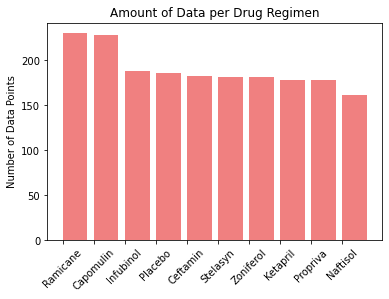

In [61]:
# General identical bar plot using pyplot instead of pandas.
x_axis = df["Drug Regimen"].unique()
tick_locations = [value for value in x_axis]

plt.bar(x_axis, df["Drug Regimen"].value_counts(), align="edge", color="lightcoral")
plt.xticks(tick_locations, df["Drug Regimen"].unique(), rotation=45)
plt.title("Amount of Data per Drug Regimen")
plt.ylabel("Number of Data Points")
plt.show()

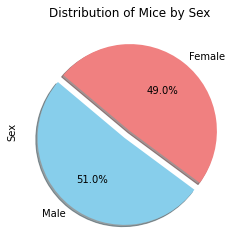

In [39]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
colors = ["skyblue", "lightcoral"]
df["Sex"].value_counts().plot.pie(title="Distribution of Mice by Sex", 
                                  colors=colors, explode=(0.1,0), 
                                  shadow=True, 
                                  autopct="%1.1f%%", 
                                  startangle=140)


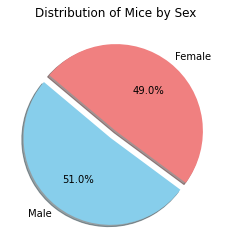

In [33]:
# Generate identical pie plot using pyplot
plt.pie(df["Sex"].value_counts(), 
        labels=df["Sex"].unique(), 
        colors=colors,
        explode = (0.1,0), 
        autopct="%1.1f%%", 
        shadow=True, 
        startangle=140)
plt.title("Distribution of Mice by Sex")
plt.show()

## Quartiles, Outliers and Boxplots

In [11]:
##### Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
mouse_gb = df.groupby("Mouse ID")
last_time = mouse_gb["Timepoint"].transform(max) == df["Timepoint"]

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
df["Final Tumor Volume"] = df[last_time]["Tumor Volume (mm3)"]

Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.

In [17]:
# Calculate quartiles, IQR, and identify potential outliers for each regimen.

fin_tumor_vol = {
    "Capomulin": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Capomulin") & df["Final Tumor Volume"]].tolist(),
    "Ramicane": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Ramicane") & df["Final Tumor Volume"]].tolist(),
    "Infubinol": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Infubinol") & df["Final Tumor Volume"]].tolist(),
    "Ceftamin": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Ceftamin") & df["Final Tumor Volume"]].tolist()
}

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

for key in fin_tumor_vol.keys():
    lowerq = np.quantile(fin_tumor_vol[key], .25)
    upperq = np.quantile(fin_tumor_vol[key], .75)
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"The IQR for {key} is {round(iqr,4)}.\n \
    Values below {round(lower_bound,4)} could be outliers.\n \
    Values above {round(upper_bound,4)} could be outliers.")

    if np.any(fin_tumor_vol[key] > upper_bound) | np.any(fin_tumor_vol[key] < lower_bound):
        print(f"*** {key} has potential outliers. ***")
    print("--------------------------------------------------------")
    

The IQR for Capomulin is 7.7819.
     Values below 20.7046 could be outliers.
     Values above 51.832 could be outliers.
--------------------------------------------------------
The IQR for Ramicane is 9.0985.
     Values below 17.9127 could be outliers.
     Values above 54.3068 could be outliers.
--------------------------------------------------------
The IQR for Infubinol is 11.4771.
     Values below 36.8329 could be outliers.
     Values above 82.7414 could be outliers.
*** Infubinol has potential outliers. ***
--------------------------------------------------------
The IQR for Ceftamin is 15.5778.
     Values below 25.3554 could be outliers.
     Values above 87.6665 could be outliers.
--------------------------------------------------------


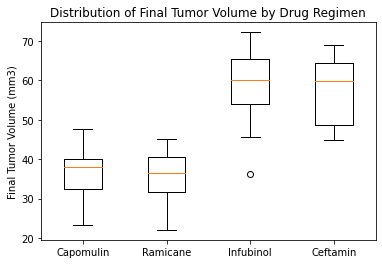

In [13]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
# There should be a single chart with four box plots inside it.
labels, data = fin_tumor_vol.keys(), fin_tumor_vol.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel("Final Tumor Volume (mm3)")
plt.title("Distribution of Final Tumor Volume by Drug Regimen")
plt.show()

## Line and Scatter Plots

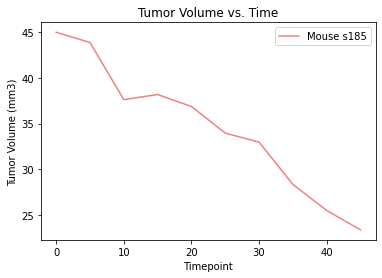

In [76]:
# Generate a line plot of tumor volume vs. time point for a single mouse 
# treated with Capomulin
s185_time = df["Timepoint"].loc[(df["Drug Regimen"]=="Capomulin") & (df["Mouse ID"]=="s185")]
s185_vol = df["Tumor Volume (mm3)"].loc[(df["Drug Regimen"]=="Capomulin") & (df["Mouse ID"]=="s185")]

plt.plot(s185_time, s185_vol, color="lightcoral")
plt.title("Tumor Volume vs. Time")
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume (mm3)")
plt.legend(['Mouse s185'], loc=0)

plt.show()

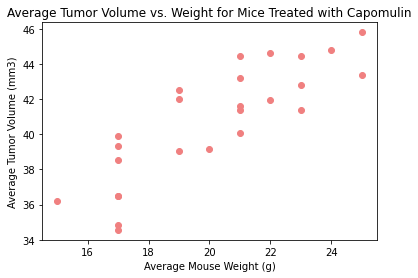

In [62]:
# Generate a scatter plot of average tumor volume vs. mouse weight 
# for all mice in the Capomulin regimen
mouse_weight = df["Weight (g)"].loc[df["Drug Regimen"]=="Capomulin"].groupby(df["Mouse ID"]).mean()
mouse_tumor = df["Tumor Volume (mm3)"].loc[df["Drug Regimen"]=="Capomulin"].groupby(df["Mouse ID"]).mean()

plt.scatter(mouse_weight, mouse_tumor, color="lightcoral")
plt.title("Average Tumor Volume vs. Weight for Mice Treated with Capomulin")
plt.xlabel("Average Mouse Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The data can be approximated with y = 0.95x + 21.55. 
The correlation coefficient r is 0.84. 
Rsquared is 0.71


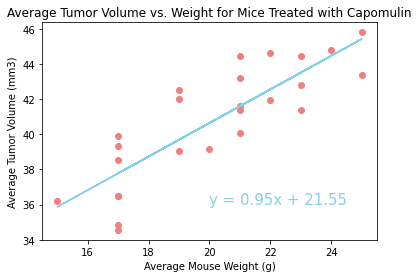

In [80]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = linregress(mouse_weight, mouse_tumor)
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"
regress_values = mouse_weight * slope + intercept
print(f"The data can be approximated with {line_eq}. \nThe correlation coefficient r is {round(rvalue,2)}. \nRsquared is {round(rvalue**2,2)}")

plt.scatter(mouse_weight, mouse_tumor, color="lightcoral")
plt.plot(mouse_weight, regress_values, color="skyblue")
plt.annotate(line_eq, (20,36), fontsize=15, color="skyblue")
plt.title("Average Tumor Volume vs. Weight for Mice Treated with Capomulin")
plt.xlabel("Average Mouse Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()


# Observations and Insights